In [18]:
import gymnasium as gym
from bettermdptools.utils.blackjack_wrapper import BlackjackWrapper
from bettermdptools.utils.test_env import TestEnv
from bettermdptools.algorithms.planner import Planner
from bettermdptools.algorithms.rl import RL
from bettermdptools.utils.plots import Plots
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
from bettermdptools.utils.decorators import add_to
import numpy as np
import seaborn as sns
import functools
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import time

sns.set_context('paper') 
sns.set_palette('bright')
np.random.seed(12345)


In [3]:
_env = gym.make('Blackjack-v1', render_mode=None, sab = True)
blackjack = BlackjackWrapper(_env)


gamma_values = [1, .9999, .999, .99, .95, .9, .85, .8, .75, .7, .65, .6, .55, .5, .45, .4, .35, .3, .25, .2, .15, .1, .05]
blackjack_df = pd.DataFrame()
blackjack_df.index = gamma_values

In [4]:
#We need to override the policy_iter, and value_iter methods to return the number of iterations used
"""print_runtime decorator from bettermdptoolbox"""
def print_runtime(func):
    @functools.wraps(func)
    def wrapper_print_runtime(*args, **kwargs):
        start = time.time()
        value = func(*args, **kwargs)
        end = time.time()
        running_time = end - start
        print("runtime = %.2f seconds" % running_time)
        return value
    return wrapper_print_runtime

@print_runtime
def policy_iteration(self, gamma=1.0, n_iters=50, theta=1e-10):
    """
    PARAMETERS:

    gamma {float}:
        Discount factor

    n_iters {int}:
        Number of iterations

    theta {float}:
        Convergence criterion for policy evaluation.
        State values are considered to be converged when the maximum difference between new and previous state
        values is less than theta.


    RETURNS:

    V {numpy array}, shape(possible states):
        State values array

    V_track {numpy array}, shape(n_episodes, nS):
        Log of V(s) for each iteration

    pi {lambda}, input state value, output action value:
        Policy mapping states to actions.
    """
    random_actions = np.random.choice(tuple(self.P[0].keys()), len(self.P))

    pi = {s: a for s, a in enumerate(random_actions)}
    # initial V to give to `policy_evaluation` for the first time
    V = np.zeros(len(self.P), dtype=np.float64)
    V_track = np.zeros((n_iters, len(self.P)), dtype=np.float64)
    i = 0
    converged = False
    while i < n_iters-1 and not converged:
        i += 1
        old_pi = pi
        V = self.policy_evaluation(pi, V, gamma, theta)
        V_track[i] = V
        pi = self.policy_improvement(V, gamma)
        if old_pi == pi:
            converged = True
    if not converged:
        warnings.warn("Max iterations reached before convergence.  Check n_iters.")
    return V, V_track, pi, i

@print_runtime
def value_iteration(self, gamma=1.0, n_iters=1000, theta=1e-10):
        """
        PARAMETERS:

        gamma {float}:
            Discount factor

        n_iters {int}:
            Number of iterations

        theta {float}:
            Convergence criterion for value iteration.
            State values are considered to be converged when the maximum difference between new and previous state values is less than theta.
            Stops at n_iters or theta convergence - whichever comes first.


        RETURNS:

        V {numpy array}, shape(possible states):
            State values array

        V_track {numpy array}, shape(n_episodes, nS):
            Log of V(s) for each iteration

        pi {lambda}, input state value, output action value:
            Policy mapping states to actions.
        """
        V = np.zeros(len(self.P), dtype=np.float64)
        V_track = np.zeros((n_iters, len(self.P)), dtype=np.float64)
        i = 0
        converged = False
        while i < n_iters-1 and not converged:
            i += 1
            Q = np.zeros((len(self.P), len(self.P[0])), dtype=np.float64)
            for s in range(len(self.P)):
                for a in range(len(self.P[s])):
                    for prob, next_state, reward, done in self.P[s][a]:
                        Q[s][a] += prob * (reward + gamma * V[next_state] * (not done))
            if np.max(np.abs(V - np.max(Q, axis=1))) < theta:
                converged = True
            V = np.max(Q, axis=1)
            V_track[i] = V
        if not converged:
            warnings.warn("Max iterations reached before convergence.  Check theta and n_iters.  ")

        pi = {s:a for s, a in enumerate(np.argmax(Q, axis=1))}
        return V, V_track, pi, i




"""
Taken from https://github.com/jlm429/bettermdptools/blob/master/notebooks/plots.ipynb
"""
@add_to(Plots)
@staticmethod
def plot_bj_policy(val_max, directions, map_size, title, file_name = None):
    """Plot the policy learned."""
    sns.heatmap(
        val_max,
        annot=directions,
        fmt="",
        cmap=sns.color_palette("magma_r", as_cmap=True),
        linewidths=0.7,
        linecolor="black",
    ).set(title=title)
    img_title = f"Policy_{map_size[0]}x{map_size[1]}.png"
    plt.show()





Planner.policy_iteration = policy_iteration
Planner.value_iteration = value_iteration

In [73]:
curr_results = []
bj_value_niters = []
for gamma in gamma_values:
    # run VI
    V, V_track, pi, iters = Planner(blackjack.P).value_iteration(gamma, 10000, 10e-15)

    #test policy
    test_scores = TestEnv.test_env(env=blackjack, n_iters=100000, render=False, pi=pi, user_input=False)
    curr_results.append(np.mean(test_scores))
    bj_value_niters.append(iters)


blackjack_df['Value Iteration'] = curr_results
blackjack_df['Value Used Iterations'] = bj_value_niters
curr_results = []
bj_policy_niters = []
for gamma in gamma_values:
    # run VI
    V, V_track, pi, iters = Planner(blackjack.P).policy_iteration(gamma, 10000, 10e-15)

    #test policy
    test_scores = TestEnv.test_env(env=blackjack, n_iters=100000, render=False, pi=pi, user_input=False)
    curr_results.append(np.mean(test_scores))
    bj_policy_niters.append(iters)

blackjack_df['Policy Iteration'] = curr_results
blackjack_df['Policy Used Iterations'] = bj_policy_niters


runtime = 0.02 seconds
runtime = 0.01 seconds
runtime = 0.01 seconds
runtime = 0.01 seconds
runtime = 0.01 seconds
runtime = 0.01 seconds
runtime = 0.01 seconds
runtime = 0.01 seconds
runtime = 0.01 seconds
runtime = 0.01 seconds
runtime = 0.01 seconds
runtime = 0.01 seconds
runtime = 0.01 seconds
runtime = 0.01 seconds
runtime = 0.01 seconds
runtime = 0.01 seconds
runtime = 0.01 seconds
runtime = 0.01 seconds
runtime = 0.01 seconds
runtime = 0.01 seconds
runtime = 0.01 seconds
runtime = 0.01 seconds
runtime = 0.01 seconds
runtime = 0.02 seconds
runtime = 0.02 seconds
runtime = 0.02 seconds
runtime = 0.02 seconds
runtime = 0.02 seconds
runtime = 0.02 seconds
runtime = 0.02 seconds
runtime = 0.02 seconds
runtime = 0.02 seconds
runtime = 0.02 seconds
runtime = 0.02 seconds
runtime = 0.02 seconds
runtime = 0.02 seconds
runtime = 0.02 seconds
runtime = 0.02 seconds
runtime = 0.02 seconds
runtime = 0.02 seconds
runtime = 0.02 seconds
runtime = 0.02 seconds
runtime = 0.02 seconds
runtime = 0

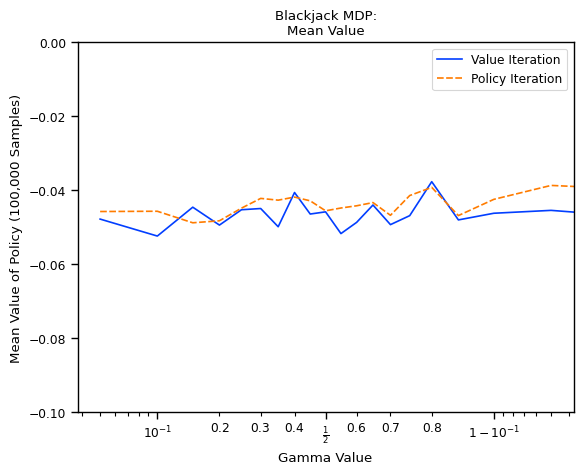

<Figure size 640x480 with 0 Axes>

In [74]:
plt.ylim(-.1, 0)
plt.xscale('logit')
plt.xlabel('Gamma Value')
plt.ylabel('Mean Value of Policy (100,000 Samples)')
sns.lineplot(blackjack_df[['Value Iteration', 'Policy Iteration']]).set_title('Blackjack MDP:\nMean Value')
plt.savefig('Fig1-BJ-Iteration')
plt.show()
plt.clf()

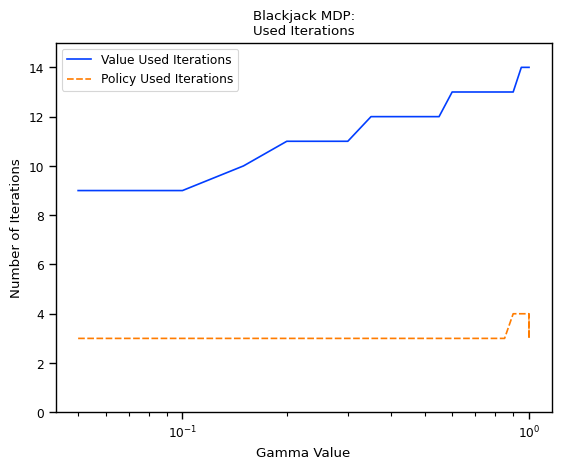

<Figure size 640x480 with 0 Axes>

In [17]:
plt.xlabel('Gamma Value')
plt.xscale('log')
plt.ylim(0, 15)
plt.ylabel('Number of Iterations')
sns.lineplot(blackjack_df[['Value Used Iterations', 'Policy Used Iterations']]).set_title('Blackjack MDP:\nUsed Iterations')
plt.savefig('Fig2-BJ-n_iters')
plt.show()
plt.clf()

In [46]:
policy_max_gamma = .999
value_max_gamma = .9999
blackjack_df['Policy Iteration']


print(max(blackjack_df['Policy Iteration']) == blackjack_df['Policy Iteration'][policy_max_gamma])
print(max(blackjack_df['Value Iteration']) == blackjack_df['Value Iteration'][value_max_gamma])
V_policy, V_track_policy, pi_policy, iters_policy = Planner(blackjack.P).policy_iteration(policy_max_gamma, 10000, 10e-15)
V_value, V_track_value, pi_value, iters_value = Planner(blackjack.P).value_iteration(value_max_gamma, 10000, 10e-15)

True
True
runtime = 0.03 seconds
runtime = 0.01 seconds


In [55]:
#compare difference in policy

count = 0

for i in range(290):
    if pi_value[i] != pi_policy[i]:
        count += 1

print(count)

0


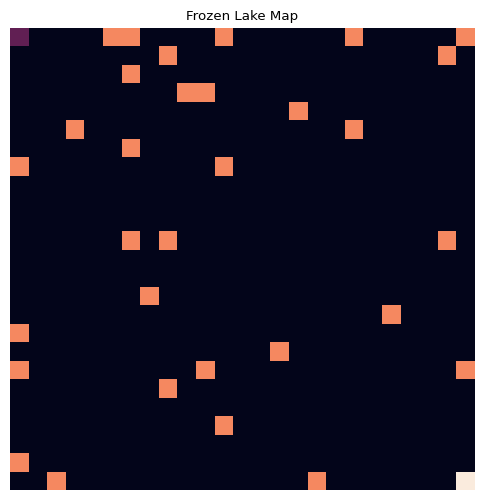

In [7]:
lake_map = ['SFFFFHHFFFFHFFFFFFHFFFFFH',
 'FFFFFFFFHFFFFFFFFFFFFFFHF',
 'FFFFFFHFFFFFFFFFFFFFFFFFF',
 'FFFFFFFFFHHFFFFFFFFFFFFFF',
 'FFFFFFFFFFFFFFFHFFFFFFFFF',
 'FFFHFFFFFFFFFFFFFFHFFFFFF',
 'FFFFFFHFFFFFFFFFFFFFFFFFF',
 'HFFFFFFFFFFHFFFFFFFFFFFFF',
 'FFFFFFFFFFFFFFFFFFFFFFFFF',
 'FFFFFFFFFFFFFFFFFFFFFFFFF',
 'FFFFFFFFFFFFFFFFFFFFFFFFF',
 'FFFFFFHFHFFFFFFFFFFFFFFHF',
 'FFFFFFFFFFFFFFFFFFFFFFFFF',
 'FFFFFFFFFFFFFFFFFFFFFFFFF',
 'FFFFFFFHFFFFFFFFFFFFFFFFF',
 'FFFFFFFFFFFFFFFFFFFFHFFFF',
 'HFFFFFFFFFFFFFFFFFFFFFFFF',
 'FFFFFFFFFFFFFFHFFFFFFFFFF',
 'HFFFFFFFFFHFFFFFFFFFFFFFH',
 'FFFFFFFFHFFFFFFFFFFFFFFFF',
 'FFFFFFFFFFFFFFFFFFFFFFFFF',
 'FFFFFFFFFFFHFFFFFFFFFFFFF',
 'FFFFFFFFFFFFFFFFFFFFFFFFF',
 'HFFFFFFFFFFFFFFFFFFFFFFFF',
 'FFHFFFFFFFFFFFFFHFFFFFFFG']
lake_map_mapping = {'S': -5, 'F': -10, 'H': 5, 'G': 10}
lake_map_viz = [[lake_map_mapping[c] for c in row] for row in lake_map]
plt.figure(figsize=(6, 6))
g = sns.heatmap(lake_map_viz, cbar=False)
g.set(yticks=[])
g.set(xticks=[])
g.set_title('Frozen Lake Map')
plt.savefig('Fig3-FL-Map')



In [5]:


gamma_values = [1, .9999, .999, .99, .95, .9, .85, .8, .75, .7, .65, .6, .55, .5, .45, .4, .35, .3, .25, .2, .15, .1, .05]
lake_df = pd.DataFrame()
lake_df.index = gamma_values

In [116]:
fl_env = gym.make('FrozenLake-v1', render_mode=None, desc=lake_map)

# run VI
V, V_track, pi, iters = Planner(fl_env.P).policy_iteration(.99, 1000, 10e-8)

#test policy
test_scores = TestEnv.test_env(env=fl_env, n_iters=1000, render=False, pi=pi, user_input=False)
print(np.mean(test_scores))

runtime = 0.90 seconds


/home/dylan/Documents/School/ML/a4/a4-venv/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


0.031


In [9]:
pi

{0: 1,
 1: 2,
 2: 2,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 2,
 8: 3,
 9: 2,
 10: 0,
 11: 0,
 12: 2,
 13: 2,
 14: 2,
 15: 2,
 16: 2,
 17: 0,
 18: 0,
 19: 2,
 20: 2,
 21: 2,
 22: 0,
 23: 0,
 24: 0,
 25: 1,
 26: 1,
 27: 1,
 28: 1,
 29: 0,
 30: 1,
 31: 1,
 32: 0,
 33: 0,
 34: 2,
 35: 2,
 36: 1,
 37: 2,
 38: 2,
 39: 2,
 40: 2,
 41: 1,
 42: 1,
 43: 1,
 44: 1,
 45: 1,
 46: 1,
 47: 0,
 48: 0,
 49: 1,
 50: 1,
 51: 1,
 52: 1,
 53: 1,
 54: 1,
 55: 0,
 56: 0,
 57: 2,
 58: 1,
 59: 3,
 60: 3,
 61: 2,
 62: 2,
 63: 1,
 64: 1,
 65: 1,
 66: 1,
 67: 1,
 68: 1,
 69: 1,
 70: 1,
 71: 1,
 72: 1,
 73: 1,
 74: 1,
 75: 1,
 76: 1,
 77: 1,
 78: 1,
 79: 1,
 80: 1,
 81: 1,
 82: 1,
 83: 0,
 84: 0,
 85: 0,
 86: 2,
 87: 1,
 88: 1,
 89: 1,
 90: 3,
 91: 2,
 92: 1,
 93: 1,
 94: 1,
 95: 1,
 96: 1,
 97: 1,
 98: 1,
 99: 1,
 100: 1,
 101: 1,
 102: 1,
 103: 3,
 104: 2,
 105: 2,
 106: 2,
 107: 1,
 108: 1,
 109: 1,
 110: 1,
 111: 1,
 112: 1,
 113: 1,
 114: 0,
 115: 0,
 116: 2,
 117: 1,
 118: 3,
 119: 2,
 120: 1,
 121: 1,
 122: 1,
 12

In [69]:
curr_results = []
lake_value_niters = []
preseved_scores_value = []
for gamma in gamma_values:
    # run VI
    V, V_track, pi, iters = Planner(fl_env.P).value_iteration(gamma, 10000, 10e-15)

    #test policy
    test_scores = TestEnv.test_env(env=fl_env, n_iters=100000, render=False, pi=pi, user_input=False)
    curr_results.append(np.mean(test_scores))
    preseved_scores_value.append(test_scores)
    lake_value_niters.append(iters)
    print(np.mean(test_scores))


lake_df['Value Iteration'] = curr_results
lake_df['Value Used Iterations'] = lake_value_niters
curr_results = []
lake_policy_niters = []
preseved_scores_policy = []

for gamma in gamma_values:
    # run VI
    V, V_track, pi, iters = Planner(fl_env.P).policy_iteration(gamma, 1000, 10e-15)

    #test policy
    test_scores = TestEnv.test_env(env=fl_env, n_iters=100000, render=False, pi=pi, user_input=False)
    curr_results.append(np.mean(test_scores))
    preseved_scores_policy.append(test_scores)

    lake_policy_niters.append(iters)
    print(np.mean(test_scores))

lake_df['Policy Iteration'] = curr_results
lake_df['Policy Used Iterations'] = lake_policy_niters

runtime = 1.70 seconds
0.00572
runtime = 1.53 seconds
0.02723
runtime = 1.54 seconds
0.02813
runtime = 1.30 seconds
0.02993
runtime = 0.84 seconds
0.03068
runtime = 0.52 seconds
0.03284
runtime = 0.37 seconds
0.03157
runtime = 0.28 seconds
0.03082
runtime = 0.26 seconds


KeyboardInterrupt: 

In [ ]:
lake_df    

,Value Iteration,Value Used Iterations,Policy Iteration,Policy Used Iterations
1.0000,0.00559,699,0.00309,57
0.9999,0.02669,715,0.02630,8
0.9990,0.02832,703,0.02766,7
0.9900,0.02983,608,0.02963,7
0.9500,0.02974,371,0.03079,6
0.9000,0.03085,240,0.03229,7
0.8500,0.03181,170,0.03161,5
0.8000,0.03333,126,0.03092,7
0.7500,0.03165,99,0.03139,6
0.7000,0.03163,81,0.03143,5


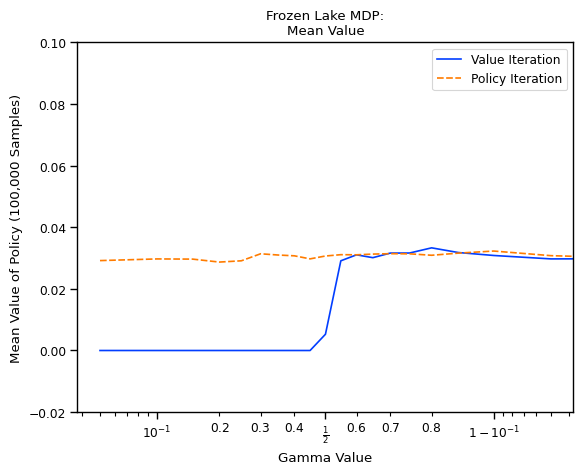

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.ylim(-.02, .1)
plt.xscale('logit')
plt.xlabel('Gamma Value')
plt.ylabel('Mean Value of Policy (100,000 Samples)')
sns.lineplot(lake_df[['Value Iteration', 'Policy Iteration']]).set_title('Frozen Lake MDP:\nMean Value')
plt.savefig('Fig4-FL-Iteration')
plt.show()
plt.clf()

In [111]:
policy_max_gamma = .9
value_max_gamma = .8


print(max(lake_df['Policy Iteration']) == lake_df['Policy Iteration'][policy_max_gamma])
print(max(lake_df['Value Iteration']) == lake_df['Value Iteration'][value_max_gamma])
V_policy, V_track_policy, pi_policy, iters_policy = Planner(fl_env.P).policy_iteration(policy_max_gamma, 10000, 10e-15)
V_value, V_track_value, pi_value, iters_value = Planner(fl_env.P).value_iteration(value_max_gamma, 10000, 10e-15)

False
False
runtime = 1.85 seconds
runtime = 0.27 seconds


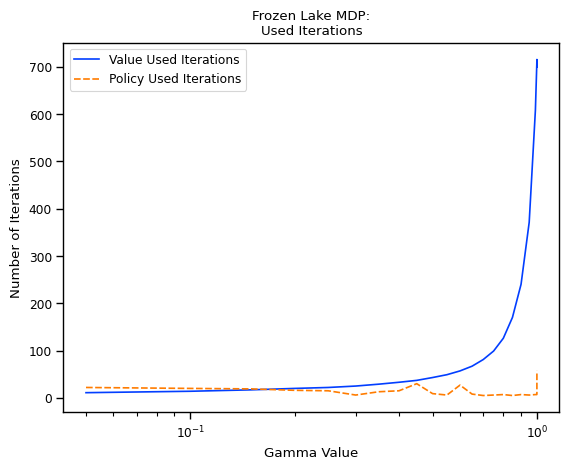

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.xlabel('Gamma Value')
plt.xscale('log')
plt.ylabel('Number of Iterations')
sns.lineplot(lake_df[['Value Used Iterations', 'Policy Used Iterations']]).set_title('Frozen Lake MDP:\nUsed Iterations')
plt.savefig('Fig5-FL-n_iters')
plt.show()
plt.clf()

In [ ]:
count = 0

for i in range(290):
    if pi_value[i] != pi_policy[i]:
        print(i)
        count += 1

print(count)

27
37
77
79
102
202
235
261
277
287
10


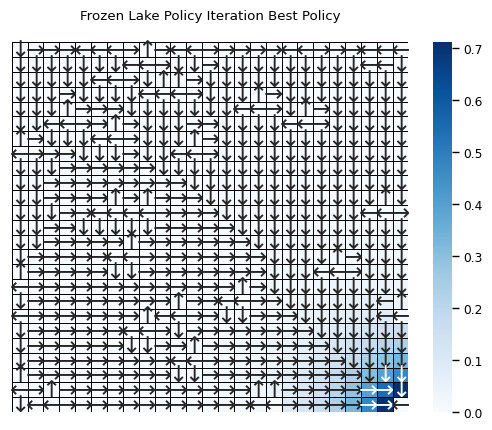

<Figure size 640x480 with 0 Axes>

In [16]:
fl_actions = {0: "←", 1: "↓", 2: "→", 3: "↑"}
fl_map_size=(25,25)
title="Frozen Lake Policy Iteration Best Policy\n"
val_max, policy_map = Plots.get_policy_map(pi_policy, V_policy, fl_actions, fl_map_size)
g = Plots.plot_policy(val_max, policy_map, fl_map_size, title)
plt.clf()

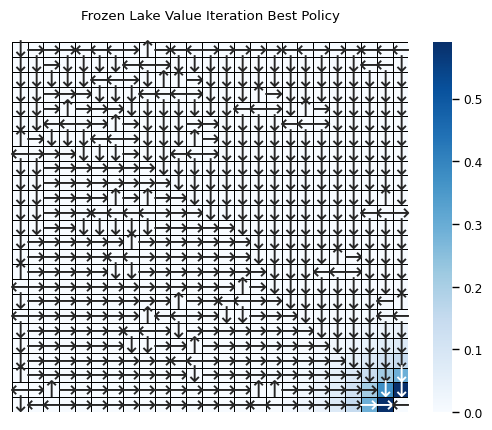

<Figure size 640x480 with 0 Axes>

In [15]:
fl_actions = {0: "←", 1: "↓", 2: "→", 3: "↑"}
fl_map_size=(25,25)
title="Frozen Lake Value Iteration Best Policy\n"
val_max, policy_map = Plots.get_policy_map(pi_value, V_value, fl_actions, fl_map_size)
Plots.plot_policy(val_max, policy_map, fl_map_size, title)
plt.savefig('Fig6-pt2')
plt.clf()

In [117]:

#Q Learning
curr_results = []
bj_q_iters = []
preseved_scores_q = []

for gamma in gamma_values:
    Q, V, pi, Q_track, pi_track= RL(blackjack).q_learning(gamma=gamma, init_alpha = .99, alpha_decay_ratio = .95, init_epsilon = 1, min_epsilon = .8, epsilon_decay_ratio = .95, n_episodes=100000)
    #test policy
    test_scores = TestEnv.test_env(env=blackjack, n_iters=100000, render=False, pi=pi, user_input=False)
    curr_results.append(np.mean(test_scores))
    preseved_scores_q.append(test_scores)

    bj_q_iters.append(iters)
    print(f'{gamma}: {np.mean(test_scores)}')


blackjack_df['Q Learner'] = curr_results

runtime = 4.16 seconds
1: -0.0433


KeyboardInterrupt: 

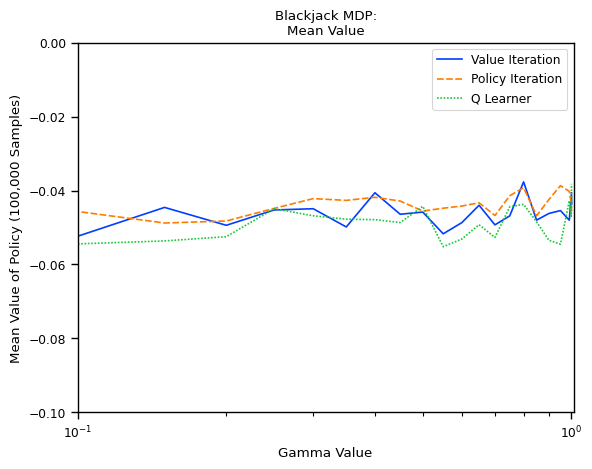

<Figure size 640x480 with 0 Axes>

In [96]:
plt.ylim(-.1, 0)
plt.xlim(.1, 1.01)
plt.xscale('log')
plt.xlabel('Gamma Value')
plt.ylabel('Mean Value of Policy (100,000 Samples)')
sns.lineplot(blackjack_df[['Value Iteration', 'Policy Iteration', 'Q Learner']]).set_title('Blackjack MDP:\nMean Value')
plt.savefig('Fig7-BJ-Iteration')
plt.show()
plt.clf()

In [153]:
q_map = ['SHFH', 'FFFH', 'HFFF', 'FHFG']

In [154]:

q_fl_env = gym.make('FrozenLake-v1', render_mode=None, desc=q_map)

In [155]:
#Q Learning
curr_results = []
fl_q_iters = []
preseved_scores_q = []
for gamma in gamma_values[10:]:
    Q, V, pi, Q_track, pi_track= RL(q_fl_env).q_learning(gamma=gamma, nS = , nA = 4, init_alpha = .5, init_epsilon = .1)
    #test policy
    test_scores = TestEnv.test_env(env=q_fl_env, n_iters=1000, render=False, pi=pi, user_input=False)

    print(pi)
    print(f'{gamma}: {np.mean(test_scores)}, {np.count_nonzero(test_scores)}')


q_lake_df = pd.DataFrame()

  0%|          | 0/10000 [00:00<?, ?it/s]/home/dylan/Documents/School/ML/a4/a4-venv/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


runtime = 0.68 seconds
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 1, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0, 68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 0, 74: 0, 75: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 0, 81: 0, 82: 0, 83: 0, 84: 0, 85: 0, 86: 0, 87: 0, 88: 0, 89: 0, 90: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 0, 97: 0, 98: 0, 99: 0, 100: 0, 101: 0, 102: 0, 103: 0, 104: 0, 105: 0, 106: 0, 107: 0, 108: 0, 109: 0, 110: 0, 111: 0, 112: 0, 113: 0, 114: 0, 115: 0, 116: 0, 117: 0, 118: 0, 119: 0, 120: 0, 121: 0, 122: 0, 123: 0, 124: 0, 125: 0, 126: 0, 127: 0, 128: 0, 129: 0, 130: 0, 131: 0, 132: 0, 133: 0, 134: 0, 135: 0

runtime = 0.60 seconds
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0, 68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 0, 74: 0, 75: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 0, 81: 0, 82: 0, 83: 0, 84: 0, 85: 0, 86: 0, 87: 0, 88: 0, 89: 0, 90: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 0, 97: 0, 98: 0, 99: 0, 100: 0, 101: 0, 102: 0, 103: 0, 104: 0, 105: 0, 106: 0, 107: 0, 108: 0, 109: 0, 110: 0, 111: 0, 112: 0, 113: 0, 114: 0, 115: 0, 116: 0, 117: 0, 118: 0, 119: 0, 120: 0, 121: 0, 122: 0, 123: 0, 124: 0, 125: 0, 126: 0, 127: 0, 128: 0, 129: 0, 130: 0, 131: 0, 132: 0, 133: 0, 134: 0, 135: 0

runtime = 0.60 seconds
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0, 68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 0, 74: 0, 75: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 0, 81: 0, 82: 0, 83: 0, 84: 0, 85: 0, 86: 0, 87: 0, 88: 0, 89: 0, 90: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 0, 97: 0, 98: 0, 99: 0, 100: 0, 101: 0, 102: 0, 103: 0, 104: 0, 105: 0, 106: 0, 107: 0, 108: 0, 109: 0, 110: 0, 111: 0, 112: 0, 113: 0, 114: 0, 115: 0, 116: 0, 117: 0, 118: 0, 119: 0, 120: 0, 121: 0, 122: 0, 123: 0, 124: 0, 125: 0, 126: 0, 127: 0, 128: 0, 129: 0, 130: 0, 131: 0, 132: 0, 133: 0, 134: 0, 135: 0

runtime = 0.61 seconds
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0, 68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 0, 74: 0, 75: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 0, 81: 0, 82: 0, 83: 0, 84: 0, 85: 0, 86: 0, 87: 0, 88: 0, 89: 0, 90: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 0, 97: 0, 98: 0, 99: 0, 100: 0, 101: 0, 102: 0, 103: 0, 104: 0, 105: 0, 106: 0, 107: 0, 108: 0, 109: 0, 110: 0, 111: 0, 112: 0, 113: 0, 114: 0, 115: 0, 116: 0, 117: 0, 118: 0, 119: 0, 120: 0, 121: 0, 122: 0, 123: 0, 124: 0, 125: 0, 126: 0, 127: 0, 128: 0, 129: 0, 130: 0, 131: 0, 132: 0, 133: 0, 134: 0, 135: 0

runtime = 0.59 seconds
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0, 68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 0, 74: 0, 75: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 0, 81: 0, 82: 0, 83: 0, 84: 0, 85: 0, 86: 0, 87: 0, 88: 0, 89: 0, 90: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 0, 97: 0, 98: 0, 99: 0, 100: 0, 101: 0, 102: 0, 103: 0, 104: 0, 105: 0, 106: 0, 107: 0, 108: 0, 109: 0, 110: 0, 111: 0, 112: 0, 113: 0, 114: 0, 115: 0, 116: 0, 117: 0, 118: 0, 119: 0, 120: 0, 121: 0, 122: 0, 123: 0, 124: 0, 125: 0, 126: 0, 127: 0, 128: 0, 129: 0, 130: 0, 131: 0, 132: 0, 133: 0, 134: 0, 135: 0

 79%|███████▉  | 7896/10000 [00:00<00:00, 19457.29it/s]/home/dylan/Documents/School/ML/a4/a4-venv/lib/python3.11/site-packages/bettermdptools/algorithms/rl.py:179: UserWarning: Episode was truncated.  Bootstrapping 0 reward.
  warnings.warn("Episode was truncated.  Bootstrapping 0 reward.")


runtime = 0.56 seconds
{0: 2, 1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 0, 7: 0, 8: 0, 9: 3, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0, 68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 0, 74: 0, 75: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 0, 81: 0, 82: 0, 83: 0, 84: 0, 85: 0, 86: 0, 87: 0, 88: 0, 89: 0, 90: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 0, 97: 0, 98: 0, 99: 0, 100: 0, 101: 0, 102: 0, 103: 0, 104: 0, 105: 0, 106: 0, 107: 0, 108: 0, 109: 0, 110: 0, 111: 0, 112: 0, 113: 0, 114: 0, 115: 0, 116: 0, 117: 0, 118: 0, 119: 0, 120: 0, 121: 0, 122: 0, 123: 0, 124: 0, 125: 0, 126: 0, 127: 0, 128: 0, 129: 0, 130: 0, 131: 0, 132: 0, 133: 0, 134: 0, 135: 0

runtime = 0.60 seconds
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0, 68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 0, 74: 0, 75: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 0, 81: 0, 82: 0, 83: 0, 84: 0, 85: 0, 86: 0, 87: 0, 88: 0, 89: 0, 90: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 0, 97: 0, 98: 0, 99: 0, 100: 0, 101: 0, 102: 0, 103: 0, 104: 0, 105: 0, 106: 0, 107: 0, 108: 0, 109: 0, 110: 0, 111: 0, 112: 0, 113: 0, 114: 0, 115: 0, 116: 0, 117: 0, 118: 0, 119: 0, 120: 0, 121: 0, 122: 0, 123: 0, 124: 0, 125: 0, 126: 0, 127: 0, 128: 0, 129: 0, 130: 0, 131: 0, 132: 0, 133: 0, 134: 0, 135: 0

runtime = 0.60 seconds
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0, 68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 0, 74: 0, 75: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 0, 81: 0, 82: 0, 83: 0, 84: 0, 85: 0, 86: 0, 87: 0, 88: 0, 89: 0, 90: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 0, 97: 0, 98: 0, 99: 0, 100: 0, 101: 0, 102: 0, 103: 0, 104: 0, 105: 0, 106: 0, 107: 0, 108: 0, 109: 0, 110: 0, 111: 0, 112: 0, 113: 0, 114: 0, 115: 0, 116: 0, 117: 0, 118: 0, 119: 0, 120: 0, 121: 0, 122: 0, 123: 0, 124: 0, 125: 0, 126: 0, 127: 0, 128: 0, 129: 0, 130: 0, 131: 0, 132: 0, 133: 0, 134: 0, 135: 0

runtime = 0.60 seconds
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0, 68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 0, 74: 0, 75: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 0, 81: 0, 82: 0, 83: 0, 84: 0, 85: 0, 86: 0, 87: 0, 88: 0, 89: 0, 90: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 0, 97: 0, 98: 0, 99: 0, 100: 0, 101: 0, 102: 0, 103: 0, 104: 0, 105: 0, 106: 0, 107: 0, 108: 0, 109: 0, 110: 0, 111: 0, 112: 0, 113: 0, 114: 0, 115: 0, 116: 0, 117: 0, 118: 0, 119: 0, 120: 0, 121: 0, 122: 0, 123: 0, 124: 0, 125: 0, 126: 0, 127: 0, 128: 0, 129: 0, 130: 0, 131: 0, 132: 0, 133: 0, 134: 0, 135: 0

runtime = 0.55 seconds
{0: 2, 1: 0, 2: 2, 3: 0, 4: 2, 5: 2, 6: 0, 7: 0, 8: 0, 9: 1, 10: 0, 11: 1, 12: 0, 13: 0, 14: 3, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0, 68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 0, 74: 0, 75: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 0, 81: 0, 82: 0, 83: 0, 84: 0, 85: 0, 86: 0, 87: 0, 88: 0, 89: 0, 90: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 0, 97: 0, 98: 0, 99: 0, 100: 0, 101: 0, 102: 0, 103: 0, 104: 0, 105: 0, 106: 0, 107: 0, 108: 0, 109: 0, 110: 0, 111: 0, 112: 0, 113: 0, 114: 0, 115: 0, 116: 0, 117: 0, 118: 0, 119: 0, 120: 0, 121: 0, 122: 0, 123: 0, 124: 0, 125: 0, 126: 0, 127: 0, 128: 0, 129: 0, 130: 0, 131: 0, 132: 0, 133: 0, 134: 0, 135: 0

runtime = 0.60 seconds
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0, 68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 0, 74: 0, 75: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 0, 81: 0, 82: 0, 83: 0, 84: 0, 85: 0, 86: 0, 87: 0, 88: 0, 89: 0, 90: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 0, 97: 0, 98: 0, 99: 0, 100: 0, 101: 0, 102: 0, 103: 0, 104: 0, 105: 0, 106: 0, 107: 0, 108: 0, 109: 0, 110: 0, 111: 0, 112: 0, 113: 0, 114: 0, 115: 0, 116: 0, 117: 0, 118: 0, 119: 0, 120: 0, 121: 0, 122: 0, 123: 0, 124: 0, 125: 0, 126: 0, 127: 0, 128: 0, 129: 0, 130: 0, 131: 0, 132: 0, 133: 0, 134: 0, 135: 0

runtime = 0.67 seconds
{0: 1, 1: 0, 2: 2, 3: 0, 4: 3, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 3, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0, 68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 0, 74: 0, 75: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 0, 81: 0, 82: 0, 83: 0, 84: 0, 85: 0, 86: 0, 87: 0, 88: 0, 89: 0, 90: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 0, 97: 0, 98: 0, 99: 0, 100: 0, 101: 0, 102: 0, 103: 0, 104: 0, 105: 0, 106: 0, 107: 0, 108: 0, 109: 0, 110: 0, 111: 0, 112: 0, 113: 0, 114: 0, 115: 0, 116: 0, 117: 0, 118: 0, 119: 0, 120: 0, 121: 0, 122: 0, 123: 0, 124: 0, 125: 0, 126: 0, 127: 0, 128: 0, 129: 0, 130: 0, 131: 0, 132: 0, 133: 0, 134: 0, 135: 0

runtime = 0.62 seconds
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0, 68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 0, 74: 0, 75: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 0, 81: 0, 82: 0, 83: 0, 84: 0, 85: 0, 86: 0, 87: 0, 88: 0, 89: 0, 90: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 0, 97: 0, 98: 0, 99: 0, 100: 0, 101: 0, 102: 0, 103: 0, 104: 0, 105: 0, 106: 0, 107: 0, 108: 0, 109: 0, 110: 0, 111: 0, 112: 0, 113: 0, 114: 0, 115: 0, 116: 0, 117: 0, 118: 0, 119: 0, 120: 0, 121: 0, 122: 0, 123: 0, 124: 0, 125: 0, 126: 0, 127: 0, 128: 0, 129: 0, 130: 0, 131: 0, 132: 0, 133: 0, 134: 0, 135: 0

ValueError: Length of values (0) does not match length of index (23)